In [45]:
from hossam import *

from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from itertools import combinations


from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
from scipy.stats import t, f, shapiro, jarque_bera


from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.graphics.gofplots import qqplot as sm_qqplot
import statsmodels.api as sm


In [46]:
origin = load_data("fish_processed")
origin.head()

농어의 길이,높이,두께,무게를 조사한 데이터의 전처리 버전


,길이,높이,두께,무게
0,8.4,2.11,1.41,1.931521
1,13.7,3.53,2.00,3.496508
2,15.0,3.82,2.43,3.713572
3,16.2,4.59,2.63,3.960813
4,17.4,4.59,2.94,4.262680


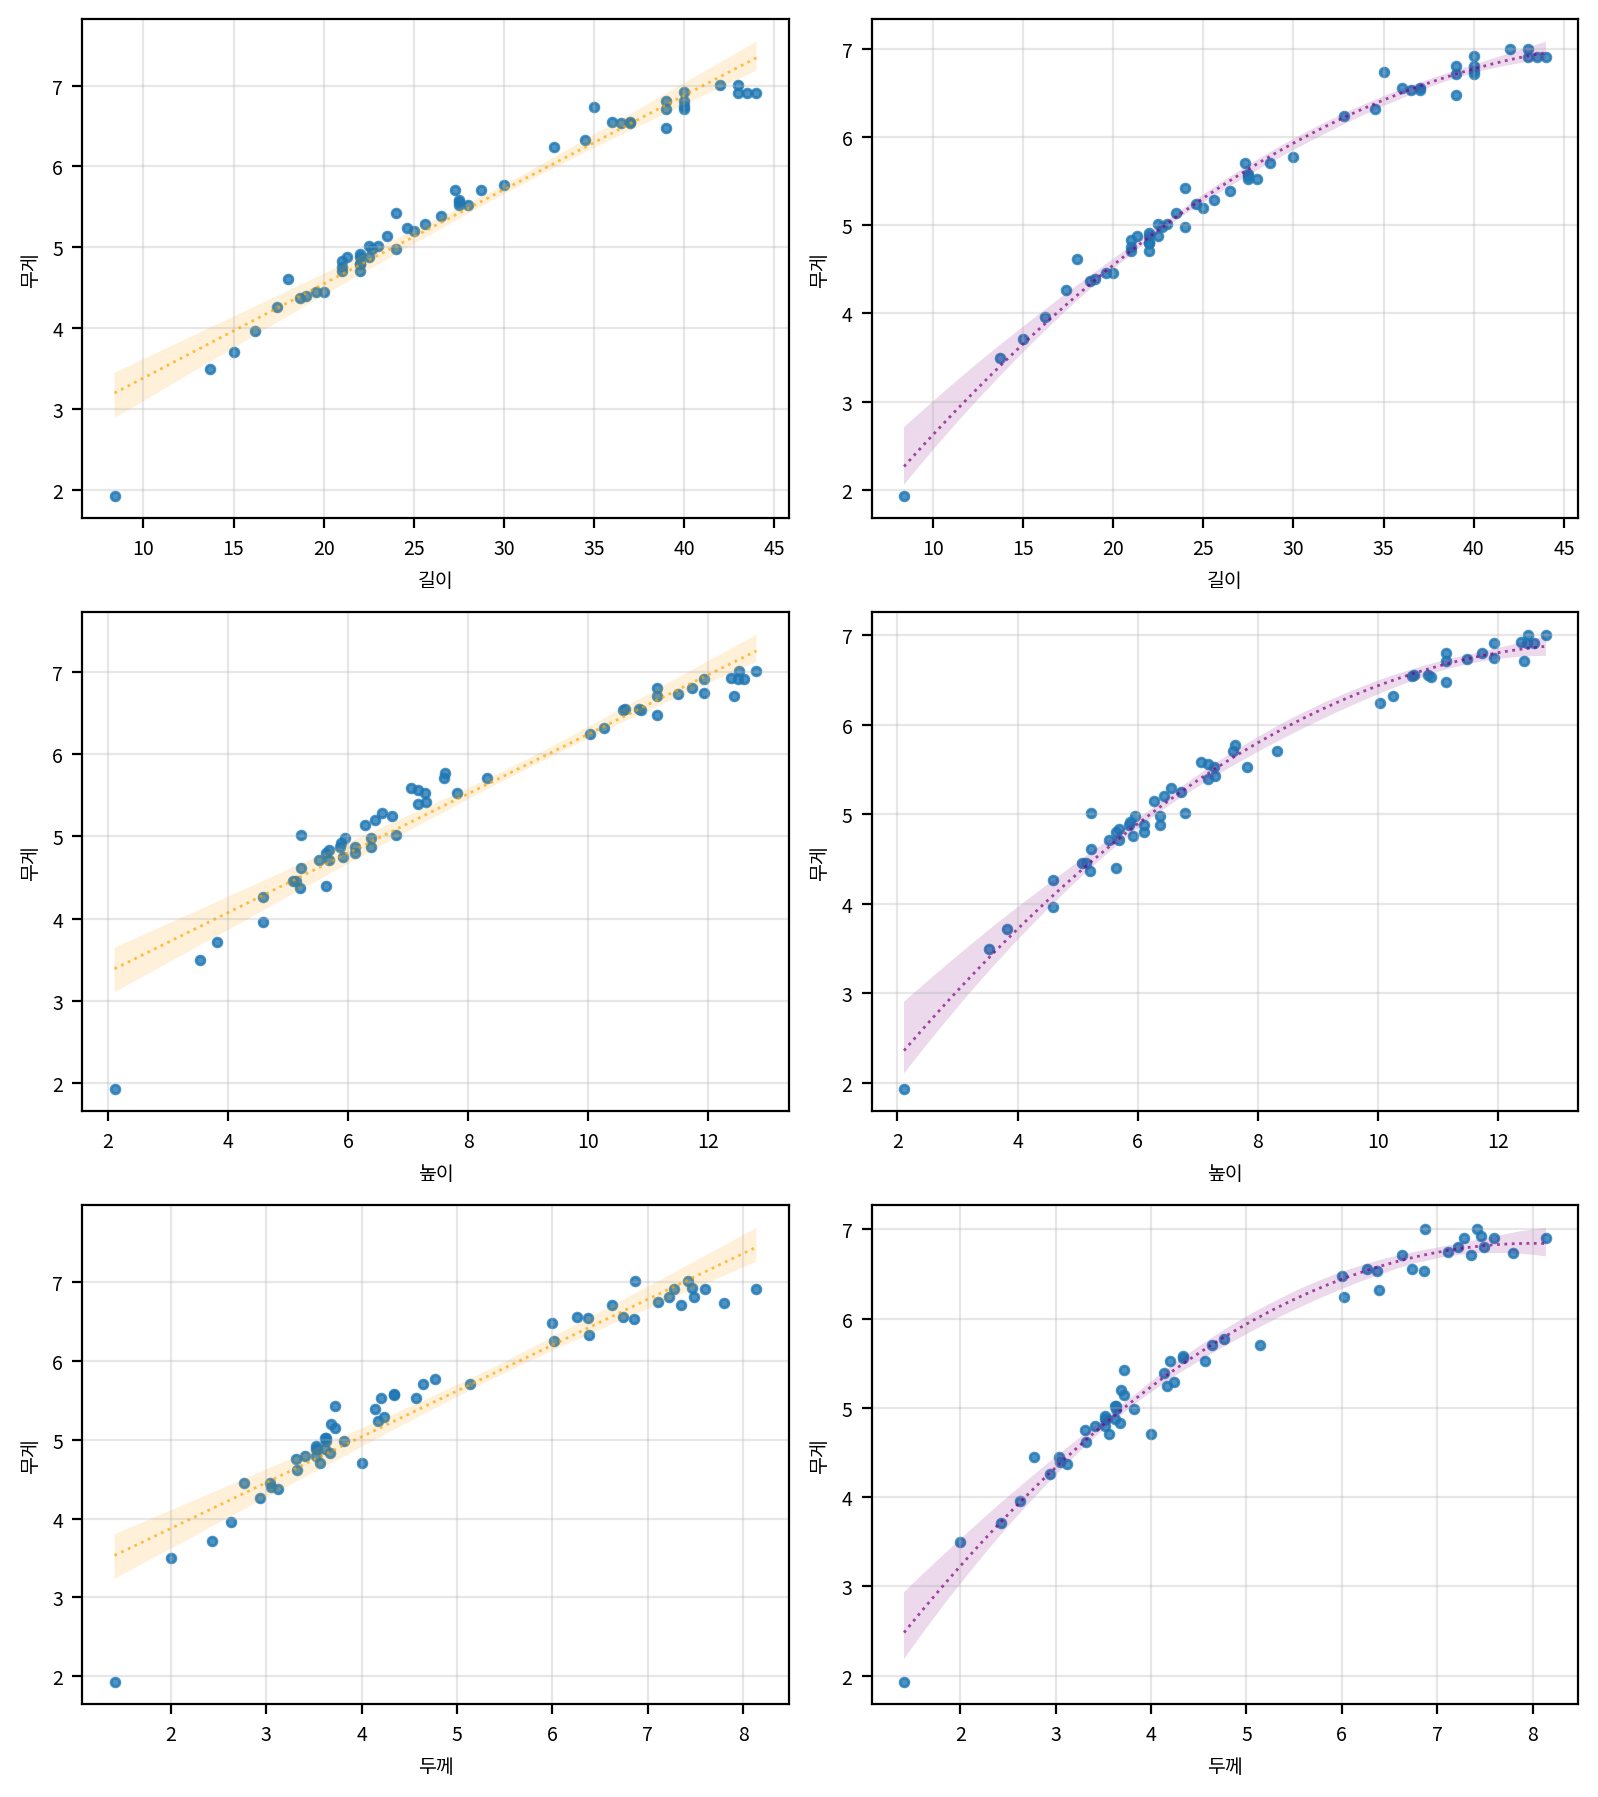

In [47]:
combo = ["길이", "높이", "두께"]
size = len(combo)

figsize = (1600/my_dpi, 600*size/my_dpi)
fig, ax = plt.subplots(size, 2, figsize= figsize, dpi=my_dpi)

for s in range(size):
    sb.regplot(
        data=origin,
        x=combo[s],
        y="무게",
        scatter_kws={"s":10},
        line_kws={"color":"orange", "linewidth":1, "alpha":0.7, "linestyle": ":"},
        ax=ax[s][0],
    )
    ax[s][0].grid(True, alpha=0.3)

    sb.regplot(
        data=origin,
        x=combo[s],
        y="무게",
        order=2,
        scatter_kws={"s":10},
        line_kws = {"color": "purple", "linewidth":1, "alpha":0.7, "linestyle": ":"},
        ax=ax[s][1],
    )
    ax[s][1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

확실히 2차곡선이 더 자연스러워 보인다.

In [48]:
df1 = origin.drop("무게", axis=1).copy()
columns = df1.select_dtypes(include=np.number).columns

for col in columns:
    df1[f"{col}**2"] = df1[col] **2

df1.head()

,길이,높이,두께,길이**2,높이**2,두께**2
0,8.4,2.11,1.41,70.56,4.4521,1.9881
1,13.7,3.53,2.00,187.69,12.4609,4.0000
2,15.0,3.82,2.43,225.00,14.5924,5.9049
3,16.2,4.59,2.63,262.44,21.0681,6.9169
4,17.4,4.59,2.94,302.76,21.0681,8.6436


In [49]:
for col1, col2 in combinations(columns, 2):
    df1[f"{col1}*{col2}"] = df1[col1] * df1[col2]

df1.head()

,길이,높이,두께,길이**2,높이**2,두께**2,길이*높이,길이*두께,높이*두께
0,8.4,2.11,1.41,70.56,4.4521,1.9881,17.724,11.844,2.9751
1,13.7,3.53,2.00,187.69,12.4609,4.0000,48.361,27.400,7.0600
2,15.0,3.82,2.43,225.00,14.5924,5.9049,57.300,36.450,9.2826
3,16.2,4.59,2.63,262.44,21.0681,6.9169,74.358,42.606,12.0717
4,17.4,4.59,2.94,302.76,21.0681,8.6436,79.866,51.156,13.4946


In [50]:
df1["무게"] = origin["무게"]
df1.head()

,길이,높이,두께,길이**2,높이**2,두께**2,길이*높이,길이*두께,높이*두께,무게
0,8.4,2.11,1.41,70.56,4.4521,1.9881,17.724,11.844,2.9751,1.931521
1,13.7,3.53,2.00,187.69,12.4609,4.0000,48.361,27.400,7.0600,3.496508
2,15.0,3.82,2.43,225.00,14.5924,5.9049,57.300,36.450,9.2826,3.713572
3,16.2,4.59,2.63,262.44,21.0681,6.9169,74.358,42.606,12.0717,3.960813
4,17.4,4.59,2.94,302.76,21.0681,8.6436,79.866,51.156,13.4946,4.262680


In [51]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_fit = poly.fit_transform(origin[["길이", "높이", "두께"]])
poly_fit[:3]

array([[  8.4   ,   2.11  ,   1.41  ,  70.56  ,  17.724 ,  11.844 ,
          4.4521,   2.9751,   1.9881],
       [ 13.7   ,   3.53  ,   2.    , 187.69  ,  48.361 ,  27.4   ,
         12.4609,   7.06  ,   4.    ],
       [ 15.    ,   3.82  ,   2.43  , 225.    ,  57.3   ,  36.45  ,
         14.5924,   9.2826,   5.9049]])

In [52]:
poly.get_feature_names_out()

array(['길이', '높이', '두께', '길이^2', '길이 높이', '길이 두께', '높이^2', '높이 두께',
       '두께^2'], dtype=object)

In [53]:
df2 = DataFrame(poly_fit, columns = poly.get_feature_names_out())

#종속변수 복사
df2["무게"] = origin["무게"]
df2.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게
0,8.4,2.11,1.41,70.56,17.724,11.844,4.4521,2.9751,1.9881,1.931521
1,13.7,3.53,2.00,187.69,48.361,27.400,12.4609,7.0600,4.0000,3.496508
2,15.0,3.82,2.43,225.00,57.300,36.450,14.5924,9.2826,5.9049,3.713572
3,16.2,4.59,2.63,262.44,74.358,42.606,21.0681,12.0717,6.9169,3.960813
4,17.4,4.59,2.94,302.76,79.866,51.156,21.0681,13.4946,8.6436,4.262680


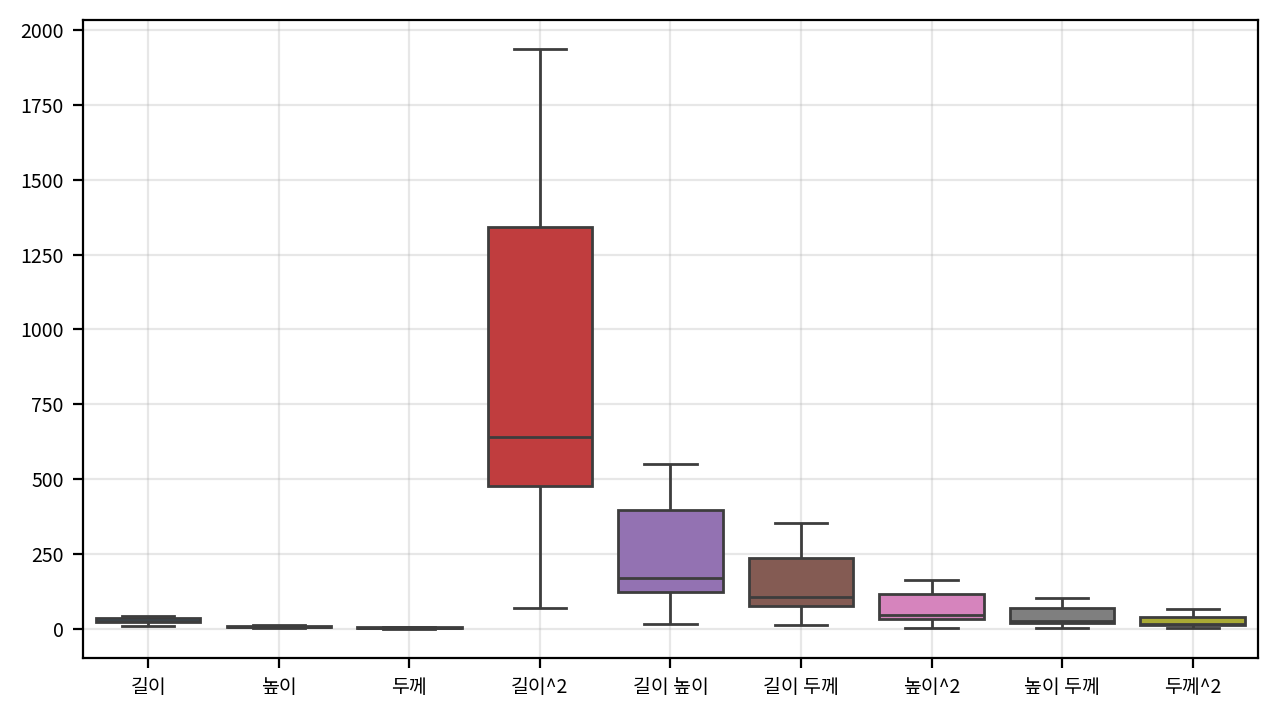

In [54]:
figsize = (1280/ my_dpi, 720/my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)
sb.boxplot(data=df2.drop("무게", axis=1))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

In [55]:
df = df2.drop("무게", axis=1)
scaler = StandardScaler()
df3 = DataFrame(scaler.fit_transform(df), columns=df.columns)
df3["무게"] = df2["무게"]
df3.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게
0,-2.180225,-2.016507,-1.896175,-1.497943,-1.428186,-1.403939,-1.358064,-1.335908,-1.300665,1.931521
1,-1.587434,-1.518703,-1.560774,-1.275113,-1.235186,-1.243176,-1.192006,-1.196934,-1.189907,3.496508
2,-1.442032,-1.417039,-1.316328,-1.204133,-1.178873,-1.149649,-1.147811,-1.121318,-1.085040,3.713572
3,-1.307815,-1.147103,-1.202633,-1.132907,-1.071415,-1.086030,-1.013541,-1.026429,-1.029328,3.960813
4,-1.173599,-1.147103,-1.026405,-1.056201,-1.036717,-0.997670,-1.013541,-0.978020,-0.934271,4.262680


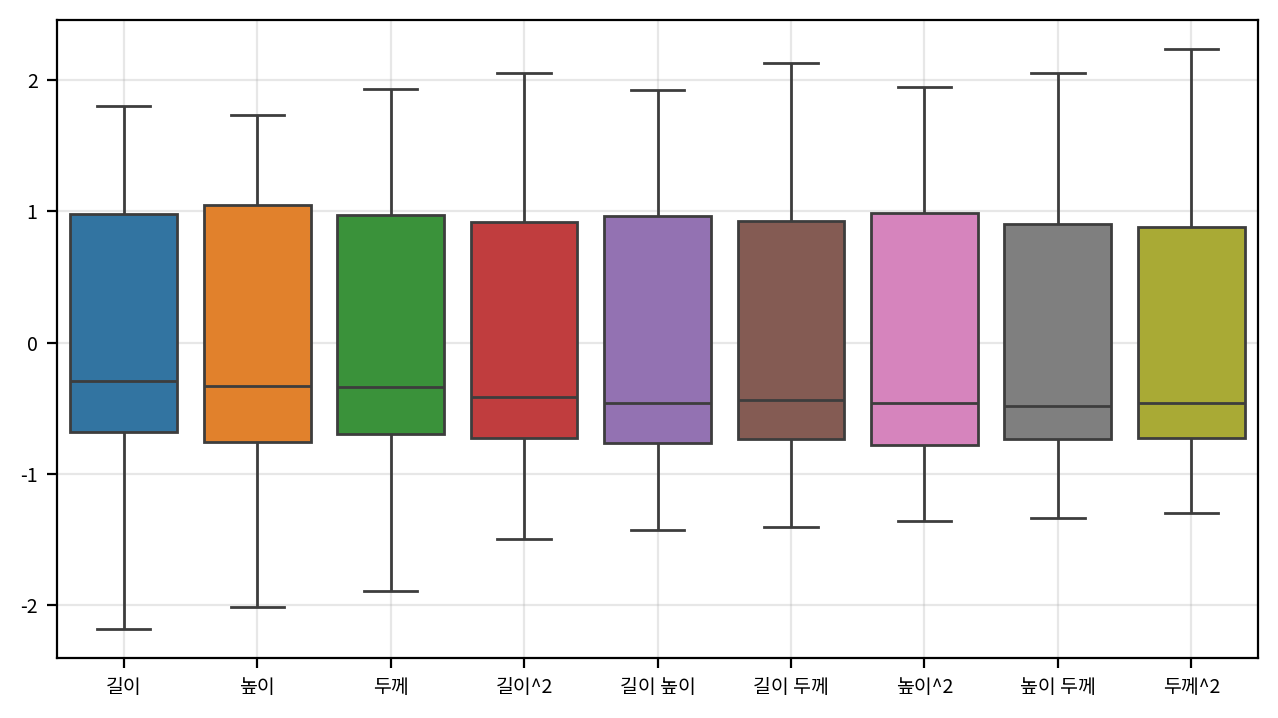

In [56]:
figsize = (1280/my_dpi, 720/my_dpi)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=my_dpi)
sb.boxplot(data=df3.drop("무게", axis=1))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

In [57]:
df3.to_excel("fish_poly_scaled.xlsx", index=False)


In [58]:
df = df3

yname="무게"
x = df.drop(columns=[yname])
y=df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size =0.25, random_state=52
)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((42, 9), (14, 9), (42,), (14,))

## 회귀모델 적합

In [59]:
estimator = LinearRegression(n_jobs=-1)
estimator.fit(x_train, y_train)
estimator

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",-1
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [60]:
y_pred = estimator.predict(x_test)

result_df =DataFrame(
    {
        "결정계수(R2)": r2_score(y_test, y_pred),
        "평균절대오차(MSE)":mean_absolute_error(y_test, y_pred),
        "평균제곱오차(MSE)":mean_squared_error(y_test, y_pred),
        "평균오차(RMSE)": np.sqrt(mean_squared_error(y_test, y_pred)),
        "평균 절대 백분오차 비율(MAPE)": mean_absolute_percentage_error(y_test, y_pred),
        "평균 비율 오차 (MPE)": np.mean((y_test - y_pred)/y_test*100),
     },
     index=["성능지표"],
)

display(result_df)

,결정계수(R2),평균절대오차(MSE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차 (MPE)
성능지표,0.953864,0.137807,0.053552,0.231413,0.022988,1.509018


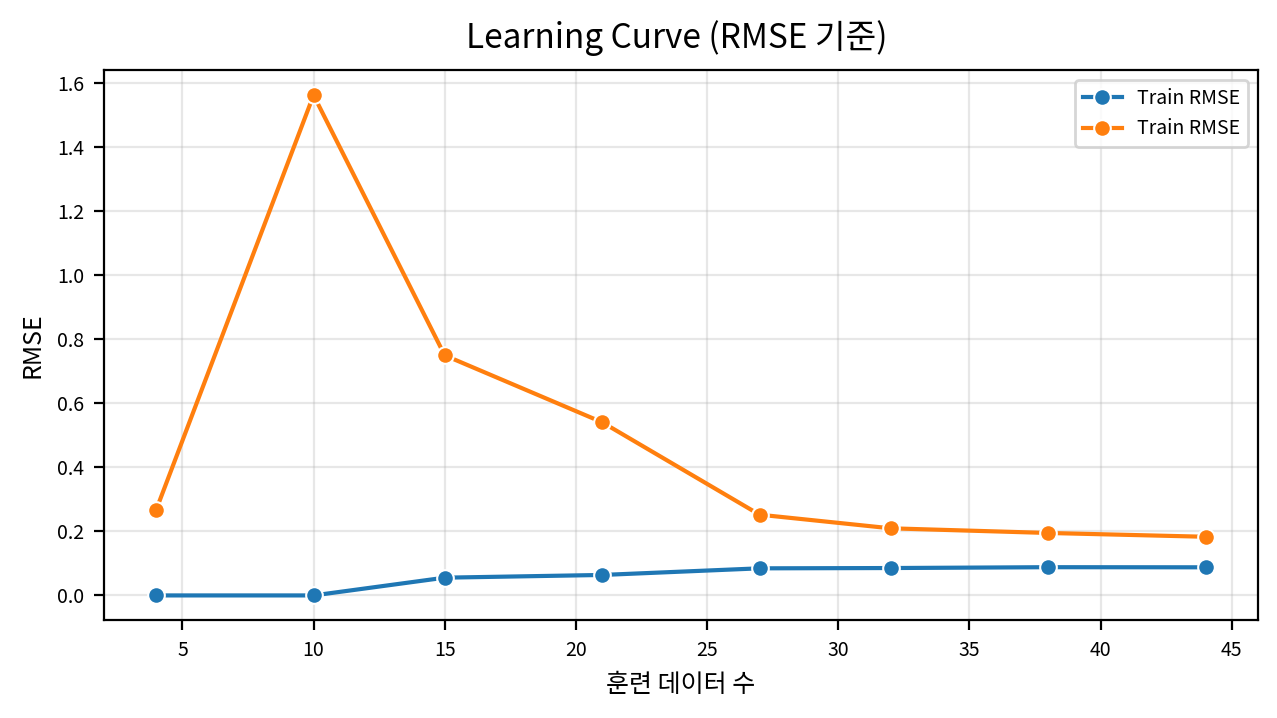

,지표,값
0,Train RMSE,0.087883
1,CV RMSE 평균,0.183345
2,CV RMSE 표준편차,0.075449
3,TRAIN/CV 비율,0.479333
4,CV 변동성 비율,0.411515
5,판정 결과,과대 적합 (일반화 실패)


In [61]:
train_sizes, train_scores, cv_scores = learning_curve(
    estimator=estimator, 
    X=x,
    y=y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 8),
    shuffle=True, 
    random_state=52,
)

train_rmse = -train_scores
cv_rmse = -cv_scores

# 평균/표준편차
train_mean = train_rmse.mean(axis=1)
cv_mean = cv_rmse.mean(axis=1)
cv_std = cv_rmse.std(axis=1)

#마지막 지점 기준 정량 판정
final_train = train_mean[-1]
final_cv= cv_mean[-1]
final_std = cv_std[-1]

gap_ratio = final_train/ final_cv
var_ratio = final_std/ final_cv

#--------------------------------------------------
#판정 로직
#--------------------------------------------------

if gap_ratio >=1.2 and var_ratio <=0.10:
    status = "과소적합 (모델이 너무 단순)"
elif gap_ratio <=0.9 and var_ratio >=0.20:
    status = "과대 적합 (일반화 실패)"
elif gap_ratio <=0.9 and var_ratio <=0.10:
    status="일반화 양호"
elif gap_ratio <=0.9 and var_ratio >0.10:
    status = "데이터 부족(표본 수 문제)"
else:
    status = "판단 유보"

#---------------------------------------------
#시각화
#---------------------------------------------
figsize = (1280/ my_dpi, 720/my_dpi)
fig, ax = plt.subplots(1, 1, figsize= figsize, dpi=my_dpi)

sb.lineplot(
    x=train_sizes,
    y=train_mean,
    marker="o",
    label="Train RMSE",
    ax=ax,

)
sb.lineplot(
    x=train_sizes,
    y=cv_mean,
    marker="o",
    label="Train RMSE",
    ax=ax,

)

ax.set_title("Learning Curve (RMSE 기준) ", fontsize=12, pad=8)
ax.set_xlabel("훈련 데이터 수", fontsize=9)
ax.set_ylabel("RMSE", fontsize=9)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()
plt.close()

#-----------------------------------------------------------
# 정량 결과 표
#------------------------------------------------------
result_df = DataFrame(
    {
        "지표":[
            "Train RMSE",
            "CV RMSE 평균",
            "CV RMSE 표준편차",
            "TRAIN/CV 비율",
            "CV 변동성 비율",
            "판정 결과",
        ],
        "값":[
            final_train,
            final_cv,
            final_std,
            gap_ratio,
            var_ratio,
            status,
        ]
    }
)
result_df

In [62]:
rdf = x_train.copy()
rdf[yname] = y_train
rdf["y_pred"] = estimator.predict(x_train)
rdf["resid"] = rdf[yname]-rdf["y_pred"]
rdf.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게,y_pred,resid
19,-0.603177,-0.701884,-0.639841,-0.669078,-0.709238,-0.684598,-0.738365,-0.715423,-0.688698,4.875197,4.908031,-0.032834
37,0.548851,0.759978,0.724503,0.414521,0.532627,0.514261,0.635524,0.617106,0.584970,6.244167,6.306256,-0.062089
40,0.962686,1.057959,1.202024,0.902320,0.961857,1.061305,1.004047,1.102121,1.180582,6.530878,6.551430,-0.020553
6,-1.028197,-0.933258,-0.924079,-0.966921,-0.927267,-0.923386,-0.889717,-0.885162,-0.874221,4.369448,4.366845,0.002603
24,-0.435406,-0.200574,-0.582993,-0.536384,-0.437662,-0.603679,-0.348465,-0.514506,-0.648290,5.420535,5.291679,0.128856


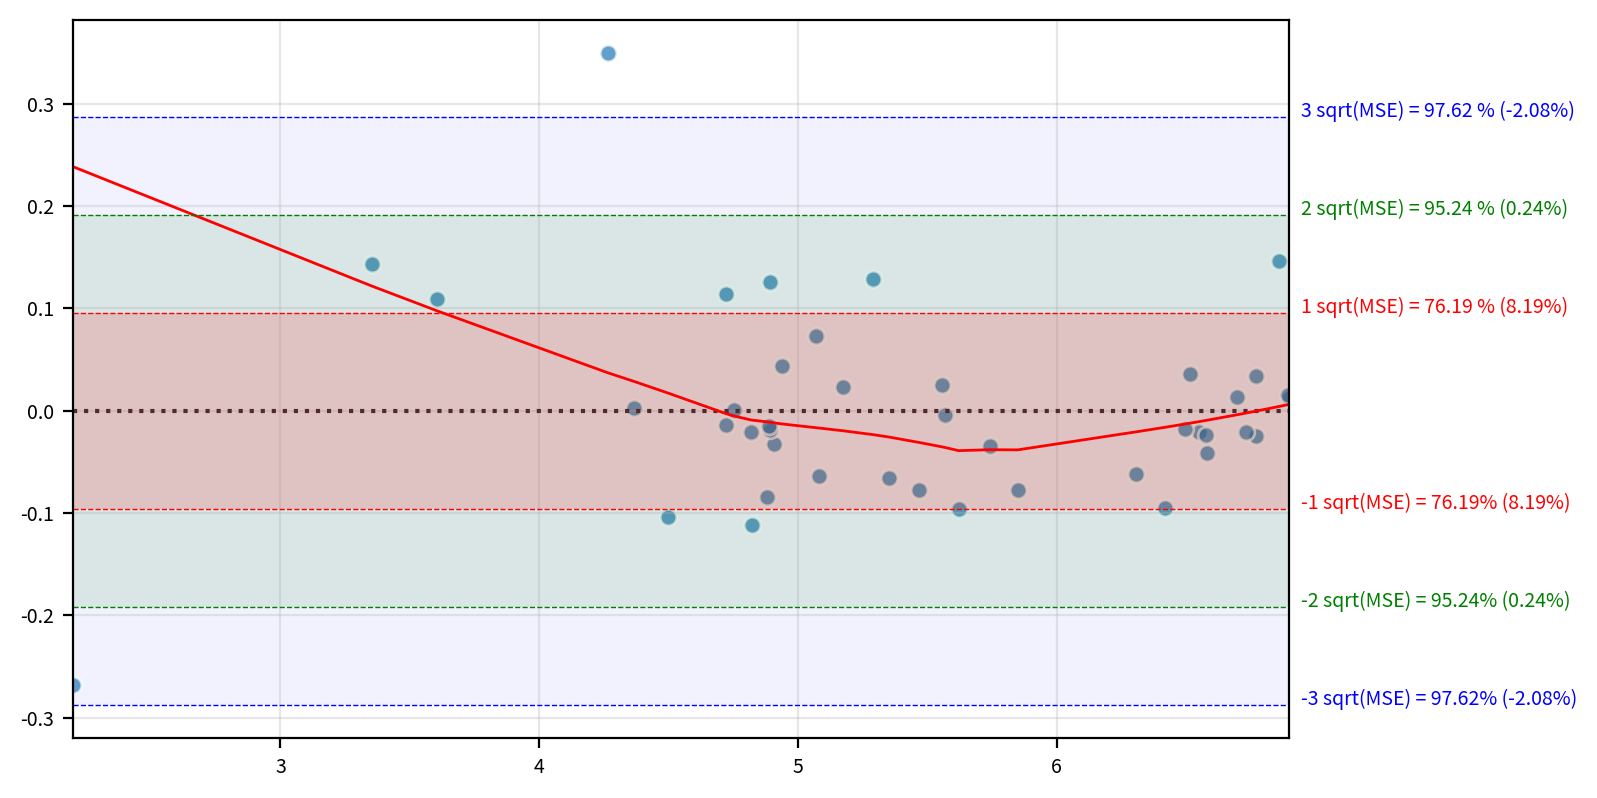

In [63]:
y = rdf[yname].values
y_pred = rdf["y_pred"].values
resid = rdf["resid"].values

figsize=(1600/ my_dpi, 800/my_dpi)
fig, ax = plt.subplots(1,1, figsize=figsize, dpi=my_dpi)

#잔차 산점도
sb.residplot(
    x=y_pred, 
    y=resid,
    lowess=True,
    line_kws={"color": "red", "linewidth":1},
    scatter_kws={"edgecolor": "white", "alpha":0.7},
)
#MSE표시
mse_val = mean_squared_error(y, y_pred)
mse_sq = np.sqrt(mse_val)

r1 = resid[(resid > -mse_sq)&(resid < mse_sq)].size/ resid.size *100
r2 = resid[(resid >-2*mse_sq)&(resid <2* mse_sq)].size/resid.size*100
r3=resid[(resid >-3*mse_sq)&(resid <3* mse_sq)].size/resid.size*100

mse_r = [r1, r2, r3]

xmin, xmax = ax.get_xlim()

#구간별 반투명 색상채우기(안쪽부터 바깥쪽으로, 진한색에서 연한색으로)
colors = ["red", "green", "blue"]
alphas = [0.15, 0.10, 0.05] #안쪽이 더 진하게

ax.axhspan(-3*mse_sq, 3*mse_sq,facecolor=colors[2], alpha=alphas[2], zorder=0 )
ax.axhspan(-2*mse_sq, 2*mse_sq,facecolor=colors[1], alpha=alphas[1], zorder=1 )
ax.axhspan(-mse_sq, mse_sq,facecolor=colors[0], alpha=alphas[0], zorder=2 )

#경계선 그리기
for i, c in enumerate(["red", "green", "blue"]):
    ax.axhline(mse_sq *(i+1), color=c, linestyle="--", linewidth=0.5)
    ax.axhline(mse_sq *(-(i+1)), color=c, linestyle="--", linewidth=0.5)

target = [68, 95, 99.7]
for i, c in enumerate(["red", "green", "blue"]):
    ax.text(
        s=f"{i+1} sqrt(MSE) = {mse_r[i]:.2f} % ({mse_r[i] - target[i]:.2f}%)",
        x=xmax +0.05,
        y=(i+1) *mse_sq,
        color=c,
    )
    ax.text(
        s=f"-{i+1} sqrt(MSE) = {mse_r[i]:.2f}% ({mse_r[i] - target[i]:.2f}%)",
        x=xmax +0.05,
        y=-(i+1) *mse_sq,
        color=c,
    )
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

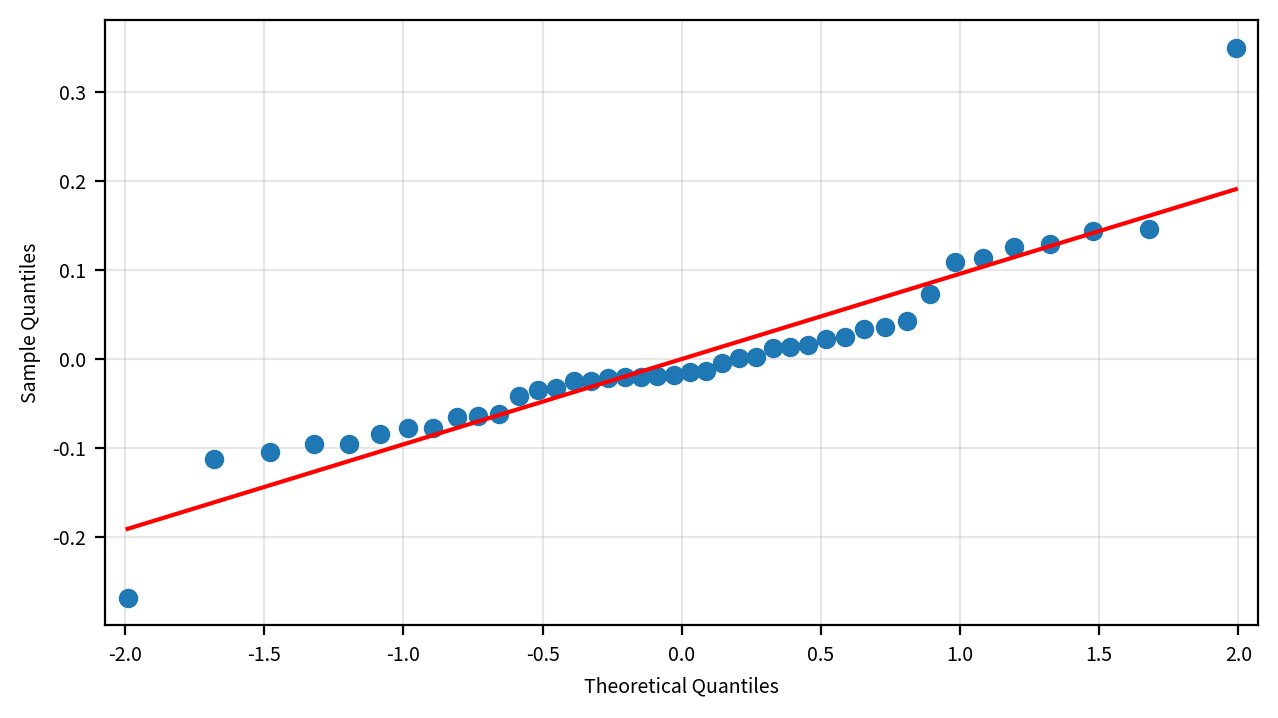

In [64]:
figsize = (1280/my_dpi, 720/my_dpi)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=my_dpi)

sm_qqplot(rdf["resid"], line="s", ax=ax)

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

In [65]:
residuals = rdf["resid"].values
n = len(residuals)
alpha=0.05
results = []

if n <5000:
    try:
        stat_sw, p_sw = shapiro(residuals)
        significant_sw = p_sw <=alpha

        if significant_sw:
            interpretation_sw = f"정규성 위반 (p={p_sw:.4f}<= {alpha})"
        else:
            interpretation_sw = f"정규성 위반 (p={p_sw:.4f}> {alpha})"
        
        results.append(
            {
                "검정": "Shapiro-Wilk",
                "검정통계량": f"{stat_sw:.4f}",
                "p-value":f"{p_sw:.4f}",
                "유의수준": alpha,
                "정규성_위반": significant_sw,
                "해석": interpretation_sw,
            }
        )
    except Exception as e:
        pass
try:
    stat_jb, p_jb = jarque_bera(residuals)
    significant_jb=p_jb <=alpha

    if significant_jb:
        interpretation_jb = f"정규성 위반 (p={p_jb:.4f} <= {alpha})"
    else:
        interpretation_jb = f"정규성 만족 (p={p_jb:.4f}>{alpha})"

    results.append(
        {
            "검정": "Jarque-Bera",
            "검정통계량": f"{stat_jb:.4f}",
            "p-value":f"{p_jb:.4f}",
            "유의수준": alpha,
            "정규성_위반": significant_jb,
            "해석": interpretation_jb,
            
        }
    )
except Exception as e:
    pass
result_df = DataFrame(results)
result_df

,검정,검정통계량,p-value,유의수준,정규성_위반,해석
0,Shapiro-Wilk,0.9086,0.0026,0.05,True,정규성 위반 (p=0.0026<= 0.05)
1,Jarque-Bera,24.5382,0.0000,0.05,True,정규성 위반 (p=0.0000 <= 0.05)


In [ ]:
resid = rdf["resid"]
alpha = 0.05
results=[]
exog = rdf.drop(columns=[yname, "y_pred", "resid"])  
exog = sm.add_constant(exog)
exog.head()

try:
    lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(resid, exog)
    significant_bp = lm_pvalue <=alpha

    if significant_bp: 
        interpretation_bp =f"등분산성 위반 (p={lm_pvalue:.4f} >{alpha})"    
    else:
        interpretation_bp= f"등분산성 만족(p={lm_pvalue:.4f}> {alpha})"
    
    results.append(
        {
            "검정": "Breusch_Pagan",
            "검정통계량 (LM)": f"{lm:.4f}",
            "p-value":f"{lm_pvalue:.4f}",
            "유의수준": alpha,
            "정규성_위반": significant_bp,
            "해석": interpretation_bp,
            

        }
    )
except Exception as e:
    pass
try:
    lm, lm_pvalue, fvalue, f_pvalue = het_white(resid, exog)
    significant_white = lm_pvalue <=alpha

    if significant_white:
        interpretation_white =f"등분산성 위반 (p={lm_pvalue:.4f} >{alpha})"
    else:
        interpretation_white= f"등분산성 만족(p={lm_pvalue:.4f}> {alpha})"
    
    results.append(
        {
            "검정": "White",
            "검정통계량 (LM)": f"{lm:.4f}",
            "p-value":f"{lm_pvalue:.4f}",
            "유의수준": alpha,
            "등분산성_위반": significant_white,
            "해석": interpretation_white,
            

        }
    )
except Exception as e:
    pass
result_df = DataFrame(results)
result_df

,검정,검정통계량 (LM),p-value,유의수준,정규성_위반,해석,등분산성_위반
0,Breusch_Pagan,24.0866,0.0042,0.05,True,등분산성 위반 (p=0.0042 >0.05),NaN
1,White,41.9329,0.1647,0.05,NaN,등분산성 만족(p=0.1647> 0.05),False


In [67]:
# 더빈왓슨 통계량 계산
dw_stat = durbin_watson(rdf["resid"])

#자기상관 판단
is_autocorrelated = dw_stat <1.5 or dw_stat>2.5

#해석 메세지 생성
if dw_stat<1.5:
    interpretation = f"DW = {dw_stat:.4f}<1.5(양의 자기상관)"
elif dw_stat>2.5:
    interpretation = f"DW = {dw_stat:.4f}>2.5(음의 자기상관)"

else:
    interpretation = f"DW = {dw_stat:.4f}(독립성 가정 만족)"

#결과 데이터 프레임 생성
result_df = DataFrame(
    {
        "검정": ["Durbin-Watson"],
        "검정통계량 (DW)": [dw_stat],
        "독립성_위반": [is_autocorrelated],
        "해석": [interpretation],
        
    }
)
result_df

,검정,검정통계량 (DW),독립성_위반,해석
0,Durbin-Watson,2.141833,False,DW = 2.1418(독립성 가정 만족)


In [1]:
yname = "무게"
xnames = list(x_train.columns)

y_train_pred = estimator.predict(x_train)

resid = y_train - y_train_pred

dw = durbin_watson(resid)

r2 = r2_score(y_train, y_train_pred)
r = np.sqrt(r2)
adj_r2 = 1-(1-r2) * (len(y_train) -1 )/(len(y_train)-len(xnames)-1)

rowcount = len(x_train)
featurecount = len(xnames)
f_statistic = (r2 /featurecount)/((1-r2)/(rowcount - featurecount-1))
p = 1-f.cdf(f_statistic, featurecount, rowcount-featurecount-1)
rdf = DataFrame(
    {
        "R": [r],
        "R**2":[r2],
        "Adj R**2": [adj_r2],
        "F": [f_statistic],
        "p-value": [p],
        "Durbin-Watson":[dw],
                }
)
display(rdf)

tpl=

SyntaxError: invalid syntax (1121497135.py, line 30)